<a href="https://colab.research.google.com/github/cassianovello/mvp_02/blob/main/DataScience_MPV_02_parte2_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP_02 - Sprint Machine Learning

##Classificador de imagens - rostos com máscara e sem máscara

###Cássia Francine Novello

**Contexto:** Temos um conjunto de imagens contendo pessoas com máscara (*with mask*) e sem máscara (*without mask*). O objetivo deste notebook é criar um modelo de visão computacional que consiga classificar as instâncias detectadas em uma imagem em alguma das categorias mencionadas acima.

Os desafios para classificação de usuários com máscara e sem máscara envolvem o posicionamento do rosto, cor ou estampa na máscara, tipos de máscara, pessoas com e sem barba, dentre outros.

Obs: neste trabalho, não será abordada a detecção das instâncias, apenas a classificação das instâncias já detectadas. Para o treino do modelo, as imagens originais foram cortadas utilizando as coordenadas de "bounding box" informadas nos arquivos complementares do próprio dataset.

**Dataset original:** Para mais informações, aqui está o link para o dataset original no Kaggle: [face-mask-detection](https://www.kaggle.com/datasets/andrewmvd/face-mask-detection?resource=download).

Para download do dataset no Google Drive:

https://drive.google.com/file/d/1oxfN8KmJTekpQ7lwgGq4yObLcbPhspQC/view?usp=drive_link


**Modelo treinado:**
https://drive.google.com/file/d/1DtVKLfzEIeMhHlYR9cVwuHiE2QcZ6mne/view?usp=sharing


**Comentários aos avaliadores**
Ambos datasets original e pós-processado estão disponilizados no meu googleDrive. Caso seja necessário realizar o download das imagens já recortadas, disponibilizei um código de execução opcional, imediatamente antes da seção 3.

Para download do dataset pós-processado no Google Drive:
https://drive.google.com/file/d/1eQR4kNuZvYcND3mAhHxXTJwOyu3_ylN7/view?usp=drive_link





## 1. Importação das bibliotecas

P.S. Para conseguir executar o notebook é necessário instalar bibliotecas como Tensorflow, keras, scikit-learn. Por exemplo:

`pip install tensorflow`

`pip install keras`

`pip install pandas`

`pip install scikit-learn`

`!pip install gdown`

`!pip install lxml`

`!pip install beautifulsoup4`

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras import optimizers
from keras.utils.vis_utils import plot_model

from keras.preprocessing import image
from tensorflow import keras


import shutil
import random
import math
import numpy as np
from datetime import datetime

import seaborn as sns

import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import confusion_matrix, classification_report
import sklearn.metrics as skm
from sklearn.model_selection import train_test_split

import itertools
from PIL import Image

In [2]:
#!pip install gdown
import gdown
import os
import zipfile

In [3]:
#!pip install lxml
#!pip install beautifulsoup4
from bs4 import BeautifulSoup


#### Utilidades

`crop_img` é uma função python que recorta uma imagem recebida como parâmetro e retorna a imagem obtida

`save_image` é uma função python que salva uma imagem recebida como parâmetro. O nome e diretório destino também são recebidos como parâmetro.


In [4]:
def crop_img(image_path, x_min, y_min, x_max, y_max):

    '''
     This function takes an image path + x and y coordinates of two opposite corners of the rectangle
     and returns a cropped image
    '''
    x_min = int(x_min)
    y_min = int(y_min)
    x_max = int(x_max)
    y_max = int(y_max)
    x_shift = (x_max - x_min) * 0.1
    y_shift = (y_max - y_min) * 0.1
    img = Image.open(image_path)
    cropped = img.crop((x_min - x_shift, y_min - y_shift, x_max + x_shift, y_max + y_shift))
    return cropped

In [5]:
def save_image(image, image_name, output_data_path):
    '''
     This function takes an image name + a path of output folder
     and saves image into the output folder
    '''

    output_path = os.path.join(output_data_path, f'{image_name}.png')
    image.save(output_path)

## 2. Acessando e tratando os dados que serão a entrada do modelo de deep learning

### 2.1 Download dos arquivos

Neste caso, temos um arquivo `.zip` que precisa ser extraído. Há uma pasta com imagens e outra pasta com arquivos xml contendo informações sobre cada imagem, inclusive seus rótulos.

In [6]:
file_id = "1oxfN8KmJTekpQ7lwgGq4yObLcbPhspQC"
url = f"https://drive.google.com/uc?id={file_id}"

folder_path = "./dataset"  # especifique a pasta onde baixara o arquivo
os.makedirs(folder_path, exist_ok=True) # cria a pasta de destino se necessário

output = "dataset/train.zip"  # especifique o nome do arquivo e a extensão do mesmo
gdown.download(url, output)

Downloading...
From: https://drive.google.com/uc?id=1oxfN8KmJTekpQ7lwgGq4yObLcbPhspQC
To: /content/dataset/train.zip
100%|██████████| 417M/417M [00:07<00:00, 59.3MB/s]


'dataset/train.zip'

In [7]:
destination = 'dataset/images/' # path onde se encontra o arquivo 'train.zip'

os.makedirs(destination,exist_ok=True) # cria a pasta de destino se necessário

with zipfile.ZipFile(output,'r') as zip_ref:
    zip_ref.extractall(destination)

Verificando a pasta das imagens

In [8]:
path='dataset/images/images/'
print(f"Primeiras 20 imagens: \n {os.listdir(path)[:20]}")
print(f"Temos um total de {len(os.listdir(path))} imagens para o treinamento e avaliação do modelo de deep learning")

Primeiras 20 imagens: 
 ['maksssksksss589.png', 'maksssksksss537.png', 'maksssksksss518.png', 'maksssksksss211.png', 'maksssksksss770.png', 'maksssksksss563.png', 'maksssksksss645.png', 'maksssksksss289.png', 'maksssksksss445.png', 'maksssksksss699.png', 'maksssksksss67.png', 'maksssksksss424.png', 'maksssksksss561.png', 'maksssksksss830.png', 'maksssksksss68.png', 'maksssksksss550.png', 'maksssksksss301.png', 'maksssksksss398.png', 'maksssksksss367.png', 'maksssksksss347.png']
Temos um total de 853 imagens para o treinamento e avaliação do modelo de deep learning


### 2.2 Preparação do dataset para o modelo

Criando um dataframe com as informações das imagens.

Tempo aproximado no Google Collab: 1min

In [9]:
images =os.listdir(path)

fnames, labels, heights, widths, channels, filesize = [], [], [], [], [], []
bbox_idx, bbox_xmin, bbox_ymin, bbox_xmax, bbox_ymax =[], [],[],[],[]

# Loop que percorre cada uma das imagens extraídas
for fname in images:

    #encontra a classe e boundingbox no arquivo xml
    with open('dataset/images/annotations/'+fname[:-4]+'.xml', 'r') as f:
      xmldata = f.read()
    Bs_data = BeautifulSoup(xmldata, "xml")
    image_classes = Bs_data.find_all('name')
    bboxes_xmin = Bs_data.find_all('xmin')
    bboxes_ymin = Bs_data.find_all('ymin')
    bboxes_xmax = Bs_data.find_all('xmax')
    bboxes_ymax = Bs_data.find_all('ymax')
    for i in range(len(image_classes)):
        bbox_idx.append(fname[:-4]+'_'+str(i))
        labels.append(image_classes[i].get_text())
        bbox_xmin.append(bboxes_xmin[i].get_text())
        bbox_ymin.append(bboxes_ymin[i].get_text())
        bbox_xmax.append(bboxes_xmax[i].get_text())
        bbox_ymax.append(bboxes_ymax[i].get_text())

        #informações da imagem
        fnames.append(fname)
        img_shape = mpimg.imread(path+fname).shape
        heights.append(img_shape[0])
        widths.append(img_shape[1])
        channels.append(img_shape[2])
        filesize.append(os.path.getsize(path+fname))

# Criação do dataset
df = pd.DataFrame({'images': fnames, 'class': labels, 'height': heights,
                         'width': widths, 'channels': channels, 'filesize': filesize, 'bbox_idx' : bbox_idx,
                          'bbox_xmin' : bbox_xmin, 'bbox_ymin': bbox_ymin, 'bbox_xmax': bbox_xmax, 'bbox_ymax': bbox_ymax})

Visualização do dataset criado

In [10]:
print(df.dtypes)
df.head()

images       object
class        object
height        int64
width         int64
channels      int64
filesize      int64
bbox_idx     object
bbox_xmin    object
bbox_ymin    object
bbox_xmax    object
bbox_ymax    object
dtype: object


,images,class,height,width,channels,filesize,bbox_idx,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax
0,maksssksksss589.png,with_mask,400,267,4,545913,maksssksksss589_0,88,95,178,185
1,maksssksksss537.png,without_mask,400,301,4,193546,maksssksksss537_0,95,177,195,295
2,maksssksksss518.png,with_mask,225,400,4,542713,maksssksksss518_0,3,112,12,122
3,maksssksksss518.png,with_mask,225,400,4,542713,maksssksksss518_1,27,178,35,186
4,maksssksksss518.png,with_mask,225,400,4,542713,maksssksksss518_2,25,107,35,117


In [11]:
#acertos de tipos
df = df.astype({'class':'string'})
df = df.astype({'bbox_idx':'string'})
df = df.astype({'bbox_xmin':'int64'})
df = df.astype({'bbox_ymin':'int64'})
df = df.astype({'bbox_xmax':'int64'})
df = df.astype({'bbox_ymax':'int64'})

df.dtypes


images       object
class        string
height        int64
width         int64
channels      int64
filesize      int64
bbox_idx     string
bbox_xmin     int64
bbox_ymin     int64
bbox_xmax     int64
bbox_ymax     int64
dtype: object

Visualizando algumas imagens do conjunto de dados

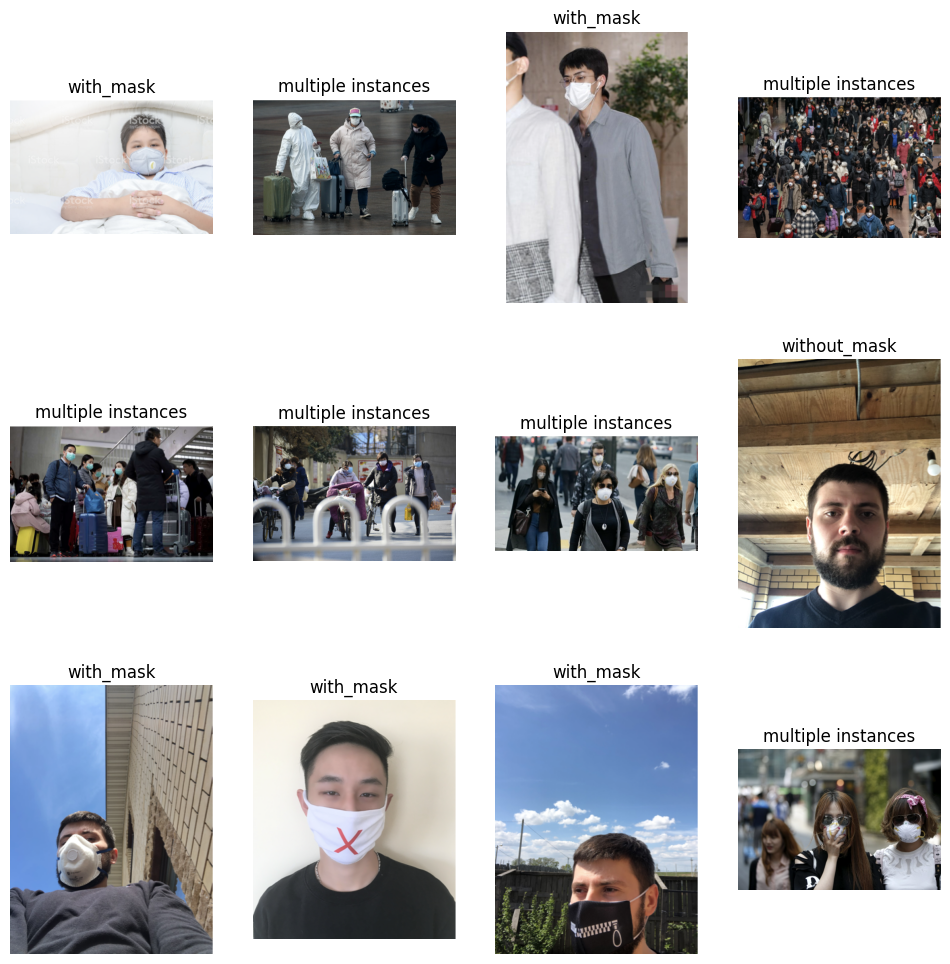

In [12]:
fig = plt.gcf()
fig.set_size_inches(3*4, 3*4)

# Visualizando apenas 12 imagens
for i in range(12):

    sample = np.random.choice(images)
    img_path =path+sample
    sp = plt.subplot(3, 4, i + 1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)

    #encontra a classe no arquivo xml
    with open('dataset/images/annotations/'+sample[:-4]+'.xml', 'r') as f:
      xmldata = f.read()
    Bs_data = BeautifulSoup(xmldata, "xml")
    imageclass = Bs_data.find_all('name')
    if len(imageclass)==1:
      imageclass = imageclass[0].get_text()
    else:
       imageclass="multiple instances"
    plt.title(imageclass)

plt.show()

Observe que cada imagem pode possuir mais de uma classe, de acordo com a quantidade de instâncias detectadas.

with_mask                3232
without_mask              717
mask_weared_incorrect     123
Name: class, dtype: Int64


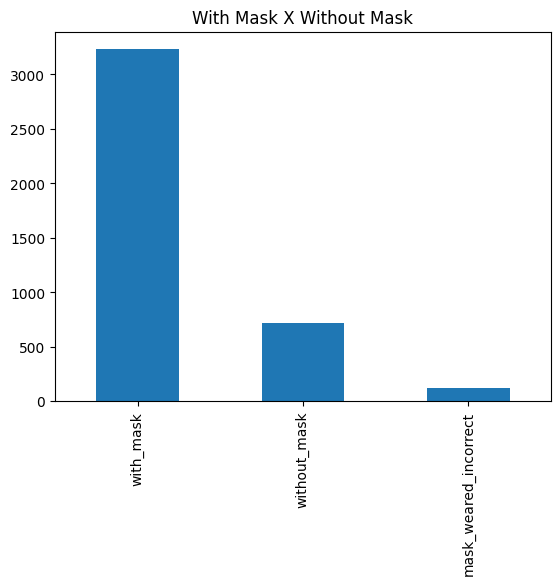

In [13]:
print(df["class"].value_counts())
mask_count = df['class'].value_counts().plot.bar(title='With Mask X Without Mask')

O dataset encontra-se desbalanceado. O balanceamento será efetuado para preparar o dataset para o modelo. Como existe uma quantidade razoável de amostras, algumas amostras da classe mais frequente (*with mask*) serão apenas desconsideradas, de forma a balancear o dataset.

A classe mask_weared_incorret será inicialmente desconsiderada, devido ao pequeno número de amostras em relação às outras classes.

In [14]:
#backup do dataset original
full_df = df

In [15]:
indexMask = df[df['class'] == 'mask_weared_incorrect'].index
df.drop(indexMask , inplace=True)
df.shape

(3949, 11)

Balanceando o dataset

In [16]:
g = df.groupby('class')
df=  pd.DataFrame(g.apply(lambda x: x.sample(717)).reset_index(drop=True))
df

,images,class,height,width,channels,filesize,bbox_idx,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax
0,maksssksksss603.png,with_mask,278,400,4,692644,maksssksksss603_80,326,18,332,26
1,maksssksksss202.png,with_mask,300,400,4,705711,maksssksksss202_1,46,126,70,153
2,maksssksksss296.png,with_mask,226,400,4,542547,maksssksksss296_19,170,130,196,153
3,maksssksksss327.png,with_mask,279,400,4,647069,maksssksksss327_3,237,137,290,186
4,maksssksksss603.png,with_mask,278,400,4,692644,maksssksksss603_23,99,165,111,177
...,...,...,...,...,...,...,...,...,...,...,...
1429,maksssksksss603.png,without_mask,278,400,4,692644,maksssksksss603_34,117,72,124,80
1430,maksssksksss179.png,without_mask,267,400,4,588676,maksssksksss179_3,89,53,116,76
1431,maksssksksss104.png,without_mask,267,400,4,638540,maksssksksss104_7,167,91,180,108
1432,maksssksksss327.png,without_mask,279,400,4,647069,maksssksksss327_2,112,46,149,73


As "bounding box" são retângulos que delimitam parte da imagem original e servem como referência para a detecção das instâncias de interesse. É necessário utilizar esta informação, uma vez que as imagens deste dataset podem conter várias pessoas com e sem máscara.

As informações das "bounding box" encontradas nos arquivos xml serão utilizadas para cortar as imagens do dataset original e preparar o dataset final para o modelo. Será utilizada a função `crop_img` declarada acima, na seção de utilidades.

In [17]:
df_cropped = df.apply(lambda row: crop_img('dataset/images/images/'+row['images'],row['bbox_xmin'],row['bbox_ymin'],row['bbox_xmax'],row['bbox_ymax']), axis=1)
df['cropped_image']=df_cropped

As imagens cortadas serão salvas no diretório "cropped".
Caso não exista, o diretório será criado.
Em seguida, as imagens serão salvas utilizando a função `save_image` declarada acima, na seção de utilidades.

In [18]:
output_data_path =  'dataset/images/cropped/'

import os
for label in labels:
        path = os.path.join(output_data_path)
        if not os.path.exists(path):
            os.makedirs(path)

In [19]:
df.apply(lambda row: save_image(row['cropped_image'],row['bbox_idx'],'dataset/images/cropped'), axis=1)
df['bbox_idx']=df['bbox_idx']+'.png'
df.head()

,images,class,height,width,channels,filesize,bbox_idx,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,cropped_image
0,maksssksksss603.png,with_mask,278,400,4,692644,maksssksksss603_80.png,326,18,332,26,<PIL.Image.Image image mode=RGBA size=8x10 at ...
1,maksssksksss202.png,with_mask,300,400,4,705711,maksssksksss202_1.png,46,126,70,153,<PIL.Image.Image image mode=RGBA size=28x33 at...
2,maksssksksss296.png,with_mask,226,400,4,542547,maksssksksss296_19.png,170,130,196,153,<PIL.Image.Image image mode=RGBA size=32x27 at...
3,maksssksksss327.png,with_mask,279,400,4,647069,maksssksksss327_3.png,237,137,290,186,<PIL.Image.Image image mode=RGBA size=63x59 at...
4,maksssksksss603.png,with_mask,278,400,4,692644,maksssksksss603_23.png,99,165,111,177,<PIL.Image.Image image mode=RGBA size=14x14 at...


Salvando as imagens cortadas em um zip.
A execução desta célula não é necessária na avaliação.

In [20]:
#!zip -r dataset/images/mask_cropped.zip dataset/images/cropped



updating: dataset/images/cropped/ (stored 0%)
updating: dataset/images/cropped/maksssksksss385_4.png (stored 0%)
updating: dataset/images/cropped/maksssksksss481_4.png (stored 0%)
updating: dataset/images/cropped/maksssksksss52_16.png (stored 0%)
updating: dataset/images/cropped/maksssksksss235_1.png (stored 0%)
updating: dataset/images/cropped/maksssksksss518_71.png (stored 0%)
updating: dataset/images/cropped/maksssksksss787_7.png (stored 0%)
updating: dataset/images/cropped/maksssksksss597_1.png (stored 0%)
updating: dataset/images/cropped/maksssksksss314_2.png (stored 0%)
updating: dataset/images/cropped/maksssksksss795_4.png (stored 0%)
updating: dataset/images/cropped/maksssksksss672_8.png (stored 0%)
updating: dataset/images/cropped/maksssksksss249_1.png (stored 0%)
updating: dataset/images/cropped/maksssksksss182_0.png (stored 0%)
updating: dataset/images/cropped/maksssksksss529_7.png (stored 0%)
updating: dataset/images/cropped/maksssksksss656_18.png (stored 0%)
updating: data

### Execução opcional, para download das imagens já cortadas
Para descomentar, pode ser usado o atalho Cntrl+/

In [21]:
# file_id = "1eQR4kNuZvYcND3mAhHxXTJwOyu3_ylN7"
# url = f"https://drive.google.com/uc?id={file_id}"

# folder_path = "./dataset/images"  # especifique a pasta onde baixara o arquivo
# os.makedirs(folder_path, exist_ok=True) # cria a pasta de destino se necessário

# output = "dataset/images/cropped.zip"  # especifique o nome do arquivo e a extensão do mesmo
# gdown.download(url, output)

In [22]:
# destination = 'dataset/images/cropped/' # path onde se encontra o arquivo .zip

# os.makedirs(destination,exist_ok=True) # cria a pasta de destino se necessário

# with zipfile.ZipFile(output,'r') as zip_ref:
#     zip_ref.extractall(destination)

## 3. Separação dos dados em treino, teste e validação

Divisão dos dados em treino e teste: 30% das imagens para teste e 70% para treinamento do modelo de deep learning. Importante lembrar que os conjuntos devem ser disjuntos, ou seja, não devem poussir nenhum elemento em comum.

In [23]:
train, test =train_test_split(df[['bbox_idx' , 'class']] ,test_size=0.3 ,random_state=42 , shuffle=True)

Visualizando a divisão dos dados

In [24]:
print("##### Train: #####")
print(train)
print(train.shape)
print("##### Test: #####")
print(test)
print(test.shape)

##### Train: #####
                    bbox_idx         class
999    maksssksksss792_1.png  without_mask
812    maksssksksss424_7.png  without_mask
1233   maksssksksss558_7.png  without_mask
754    maksssksksss723_2.png  without_mask
588    maksssksksss358_0.png     with_mask
...                      ...           ...
1095   maksssksksss852_1.png  without_mask
1130   maksssksksss318_2.png  without_mask
1294  maksssksksss240_58.png  without_mask
860    maksssksksss119_6.png  without_mask
1126   maksssksksss673_3.png  without_mask

[1003 rows x 2 columns]
(1003, 2)
##### Test: #####
                    bbox_idx         class
370    maksssksksss790_0.png     with_mask
560   maksssksksss428_16.png     with_mask
1007  maksssksksss110_23.png  without_mask
589    maksssksksss409_0.png     with_mask
983     maksssksksss52_5.png  without_mask
...                      ...           ...
570   maksssksksss354_17.png     with_mask
1418   maksssksksss543_2.png  without_mask
490    maksssksksss805_3.

#### Preparação dos dados

`ImageDataGenerator` é uma classe utilitária fornecida pelo TensorFlow para aumentar e pré-processar dados de imagens. Está classe gera um aumento do dataset realizando transformações como alteração da escala, rotação, zoom, etc. Ela também foi utilizada para separar um conjunto de validação com 20% das amostras do conjunto de treino.

Importante ressaltar que o pré-processamento do teste não evolve o aumento de dados.

As imagens do treino inicialmente tem tamanhos diversos, uma vez que são instâncias recortadas de imagens maiores do dataset original. Elas serão padronizadas para o tamanho (35,35) pelo método `flow_from_dataframe()`. Este método cria lotes de imagens para o treinamento. O tamanho do lote (batch size) utilizado foi o padrão da biblioteca, que é 32. O modo de classe será binário neste caso, porque são apenas duas classes (com máscara e sem máscara).



In [25]:
batch_size=32

train_datagen=ImageDataGenerator(validation_split=0.2, #include validation split
                                 rescale = 1.0/255,
                                    rotation_range=40,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255)


train_generator=train_datagen.flow_from_dataframe(
    train ,path,
    target_size=(35,35),
    batch_size=batch_size,
    class_mode='binary',
    x_col='bbox_idx',
    y_col='class',
    subset='training' #training set
    )

val_generator=train_datagen.flow_from_dataframe(
    train ,path,
    target_size=(35,35),
    batch_size=batch_size,
    class_mode='binary',
    x_col='bbox_idx',
    y_col='class',
    subset='validation' #validation set
    )

test_generator=test_datagen.flow_from_dataframe(
    test ,path,
    target_size=(35,35),
    batch_size=batch_size,
    class_mode='binary',
    x_col='bbox_idx',
    y_col='class',)

Found 803 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Found 431 validated image filenames belonging to 2 classes.


Visualizando um exemplo do tratamento das imagens

Found 1 validated image filenames belonging to 1 classes.


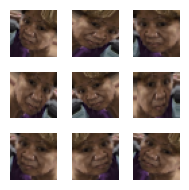

In [26]:
# Pegando um registro do dataframe
sample = df.sample(n=1)

# Neste caso o tipo de classe é categorico, pois temos um exemplo com apenas uma classe
sample_generator = train_datagen.flow_from_dataframe(
    sample,
    path,
    x_col='bbox_idx',
    y_col='class',
    target_size=(35,35),
    class_mode='categorical'
)

plt.figure(figsize=(2, 2))
for i in range(9):
    plt.subplot(3, 3, i+1)
    for x_batch, y_batch in sample_generator:
        image = x_batch[0]
        plt.imshow(image)
        plt.axis('Off')
        break
plt.tight_layout()
plt.show()

## 4. Configuração de um modelo de deep learning usando uma rede neural convolucional (CNN)

#### Definição da arquitetura do modelo

Por se tratarem de imagens pequenas, de (35,35) com 3 canais, foram necessárias somente três camadas de convolução para obter resultados satisfatórios.

As camadas de convolução variam de 32 a 128 filtros e usam a função de ativação `ReLU`, uma função bastante usada na literatura. É boa prática usar potências de dois como o número de filtros. As camadas de convolução são seguidas de uma camada de *MaxPooling* para reduzir a dimensão do espaço da saída.  O kernel definido foi (3,3), por ser um valor recomendado na literatura, e por se tratar de uma imagem pequena.

A camada *Flatten* é usada para conectar o mapa de características e as camadas totalmente conectadas do modelo.

As camadas de *Dropout* foram usadas para evitar *overfitting*, tendo como parâmetro a porcentagem de imagens que serão transformadas em zero escolhido como 0.25. De fato, os resultados obtidos não evidenciaram *overfitting*. É interessante ressaltar que o "descarte" de entradas é realizado apenas no treino, por padrão, ou seja, nenhuma imagem é descartada quando o modelo está em operação.

In [27]:
model=models.Sequential()
model.add(layers.Conv2D(32 ,(3,3) , activation='relu' , input_shape=(35,35,3 ) ) )
model.add(layers.MaxPooling2D( (2,2)))

model.add(layers.Conv2D(64 , (3,3) , activation='relu'))
model.add(layers.MaxPooling2D( (2,2)))

model.add(layers.Conv2D(128 , (3,3) , activation='relu'))
model.add(layers.MaxPooling2D( (2,2)))


In [28]:
model.add(layers.Flatten() )
model.add(layers.Dropout(0.25))
model.add(layers.Dense( 512 ,activation='relu' ))
model.add(layers.Dropout(0.25))
model.add(layers.Dense( 1 , activation='sigmoid' ) )

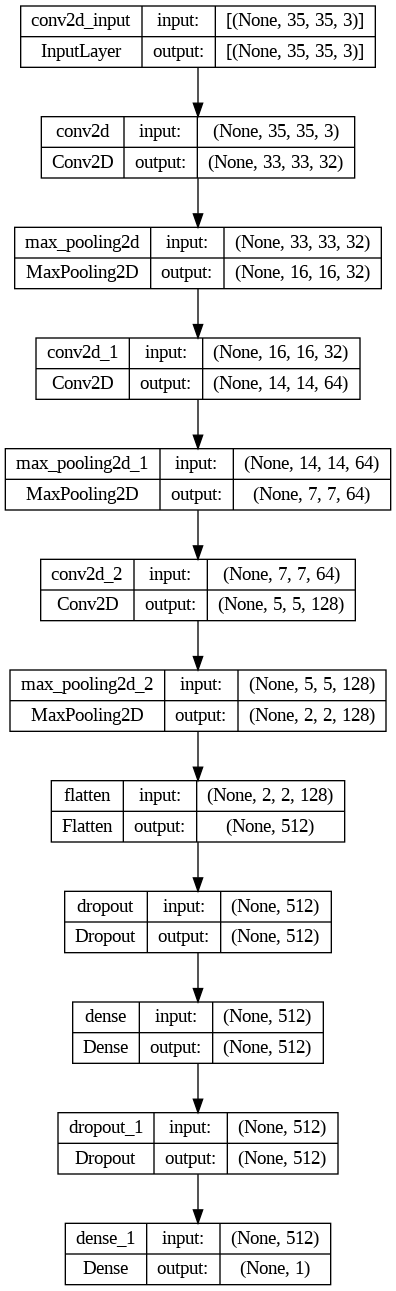

In [29]:
plot_model(model, show_shapes=True, show_layer_names=True)

## 5. Treinamento e teste do modelo de deep learning

### 5.1 Treinamento

`optimizer='adam'`: Adam é um otimizador estocástico de gradiente descendente. É computacionalmente eficiente e exige pouca memória para execução, de acordo com  [Kingma et al., 2014](https://arxiv.org/abs/1412.6980)

`loss='binary_crossentropy'`: especifica a função de perda a ser usada durante o treinamento. Para problemas de classificação binária, onde a variável alvo tem apenas duas categorias, a perda binária de entropia cruzada é freqüentemente empregada.

`metrics=['accuracy']`: a acurácia é apropriada para este problema, pois o dataset está balanceado e, a princípio, não existe diferença da importância entre detecção das classes.

In [30]:
model.compile(optimizer='adam', loss='binary_crossentropy' , metrics=['accuracy'])

Realizando experimento.




In [31]:
history=model.fit_generator(train_generator ,
                            steps_per_epoch=3,
                            epochs=20 ,
                            validation_data=val_generator ,
                            validation_steps=2)

Epoch 1/20


<ipython-input-31-690b60a86eb5>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator ,


3/3 [==============================] - 2s 399ms/step - loss: 0.7008 - accuracy: 0.4896 - val_loss: 0.6591 - val_accuracy: 0.4688
Epoch 2/20
3/3 [==============================] - 1s 188ms/step - loss: 0.6614 - accuracy: 0.5729 - val_loss: 0.6324 - val_accuracy: 0.7969
Epoch 3/20
3/3 [==============================] - 1s 193ms/step - loss: 0.6079 - accuracy: 0.6250 - val_loss: 0.5961 - val_accuracy: 0.5156
Epoch 4/20
3/3 [==============================] - 1s 195ms/step - loss: 0.5724 - accuracy: 0.6771 - val_loss: 0.5350 - val_accuracy: 0.7812
Epoch 5/20
3/3 [==============================] - 1s 181ms/step - loss: 0.5177 - accuracy: 0.8229 - val_loss: 0.3875 - val_accuracy: 0.8906
Epoch 6/20
3/3 [==============================] - 1s 242ms/step - loss: 0.3753 - accuracy: 0.8958 - val_loss: 0.4642 - val_accuracy: 0.8281
Epoch 7/20
3/3 [==============================] - 1s 311ms/step - loss: 0.3861 - accuracy: 0.8021 - val_loss: 0.2764 - val_accuracy: 0.9062
Epoch 8/20
3/3 [===============

A acurácia da validação durante o treino ultrapassou os 90%. Este será considerado um resultado satisfatório para este caso.
Vamos seguir a análise avaliando o conjunto de teste com o modelo criado.

### 5.2 Execução do modelo treinado nas imagems de teste
Abaixo é possível visualizar uma amostra dos resultados da previsão do modelo nas imagens de teste.

Em seguida, vamos avaliar os resultados.

1/1 [==============================] - 0s 133ms/step


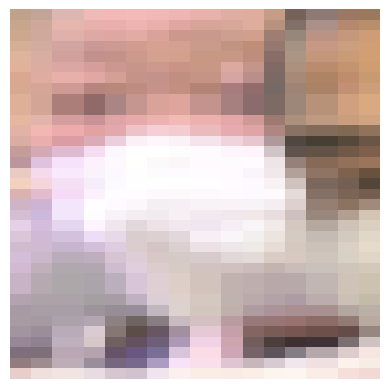

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.018026423


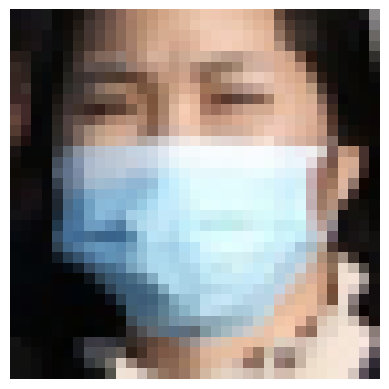

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.00017305338


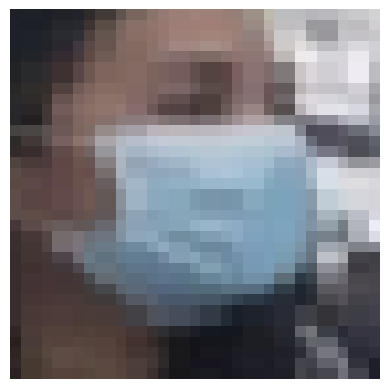

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.0007958191


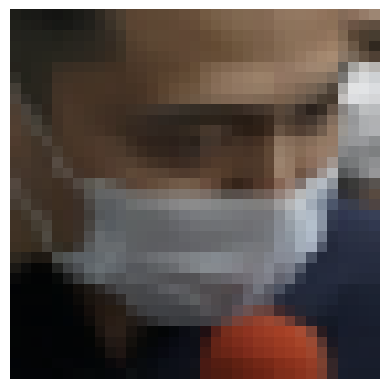

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.2149612


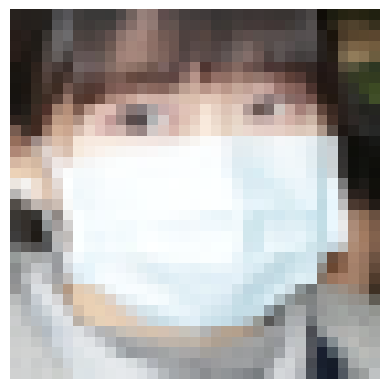

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.003695584


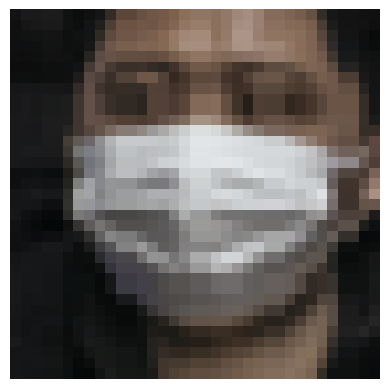

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.008400873


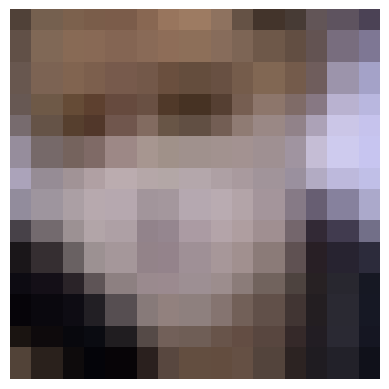

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.20601565


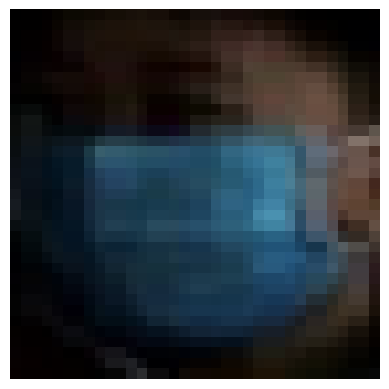

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.00085113564


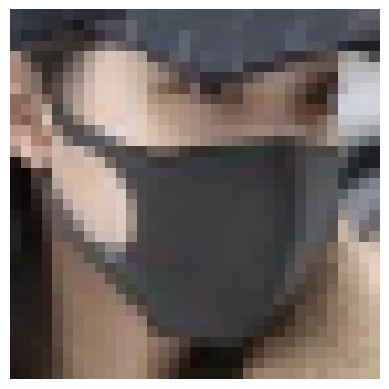

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.2615446


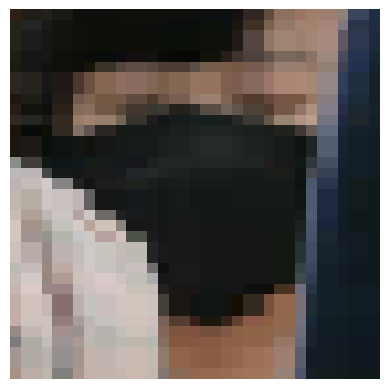

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.04238486


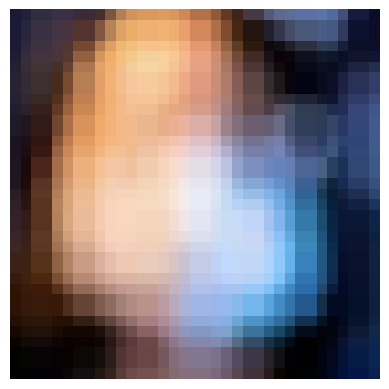

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.008093657


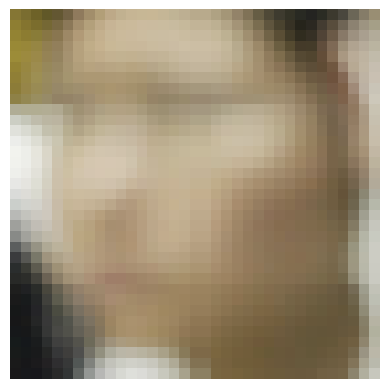

Label:  without_mask
Previsão:  without_mask
Probabilidade:  0.9695026


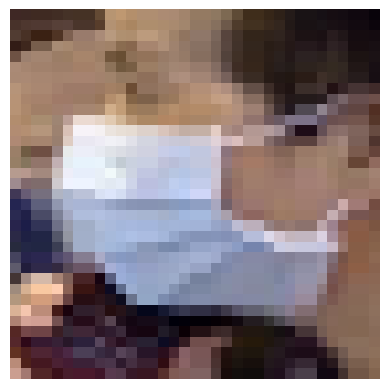

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.0007371637


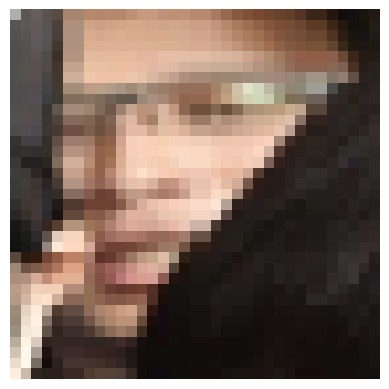

Label:  without_mask
Previsão:  without_mask
Probabilidade:  0.87637204


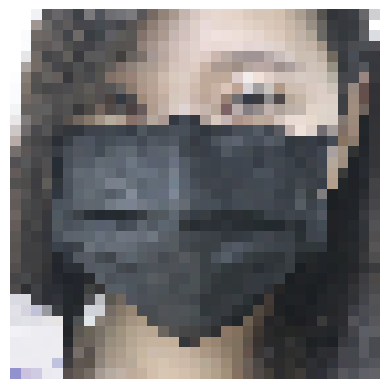

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.02111774


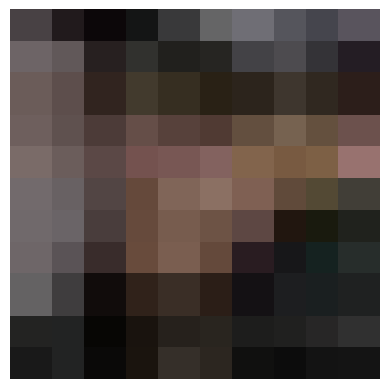

Label:  without_mask
Previsão:  without_mask
Probabilidade:  0.9190208


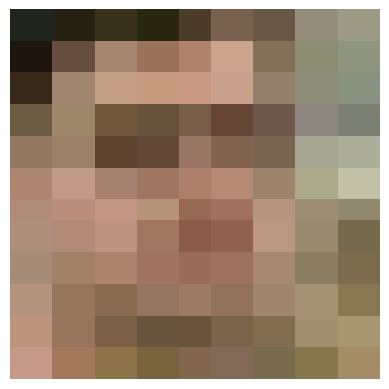

Label:  without_mask
Previsão:  without_mask
Probabilidade:  0.9753582


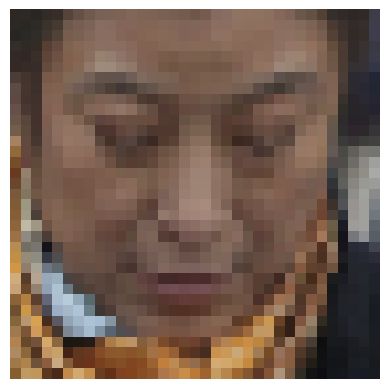

Label:  without_mask
Previsão:  without_mask
Probabilidade:  0.94336766


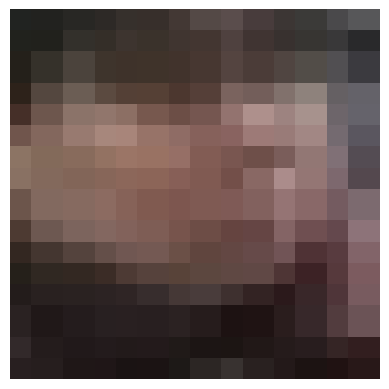

Label:  without_mask
Previsão:  without_mask
Probabilidade:  0.95057684


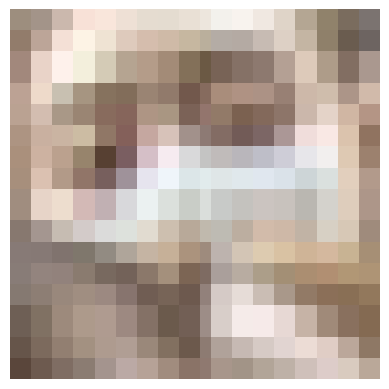

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.08896068


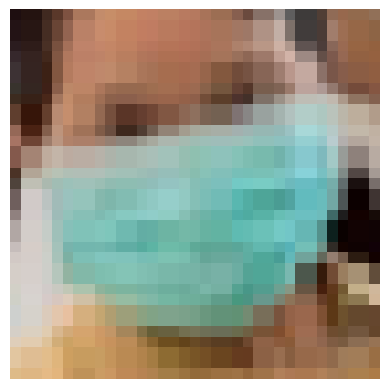

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.00012760406


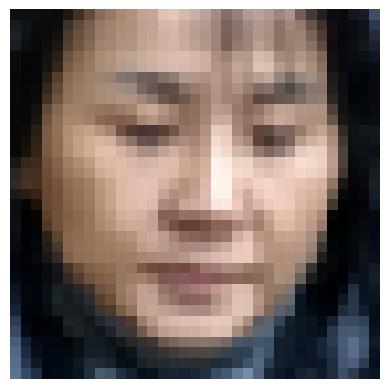

Label:  without_mask
Previsão:  without_mask
Probabilidade:  0.96111983


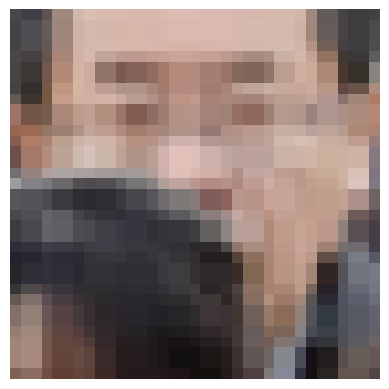

Label:  without_mask
Previsão:  without_mask
Probabilidade:  0.7342662


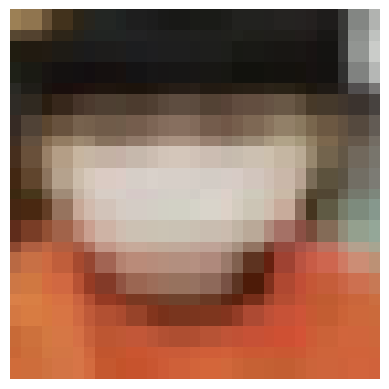

Label:  with_mask
Previsão:  without_mask
Probabilidade:  0.7052287


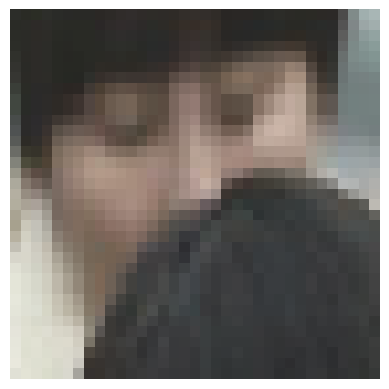

Label:  without_mask
Previsão:  without_mask
Probabilidade:  0.7679143


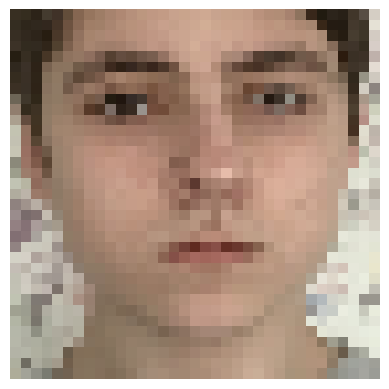

Label:  without_mask
Previsão:  without_mask
Probabilidade:  0.97756153


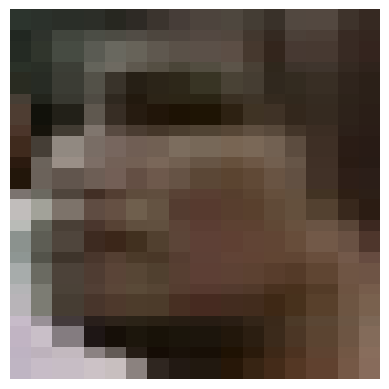

Label:  without_mask
Previsão:  without_mask
Probabilidade:  0.92353594


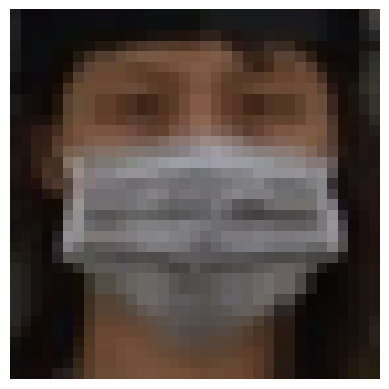

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.09992468


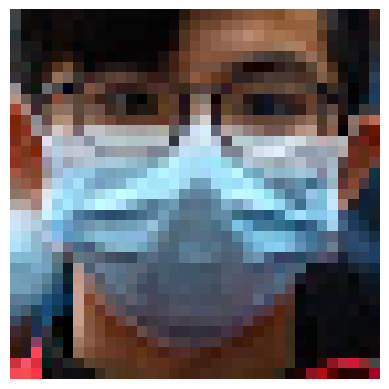

Label:  with_mask
Previsão:  with_mask
Probabilidade:  1.1070435e-05


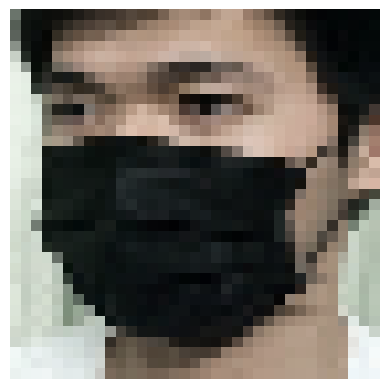

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.048884343


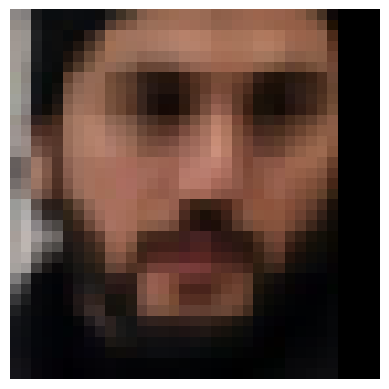

Label:  without_mask
Previsão:  without_mask
Probabilidade:  0.9704731


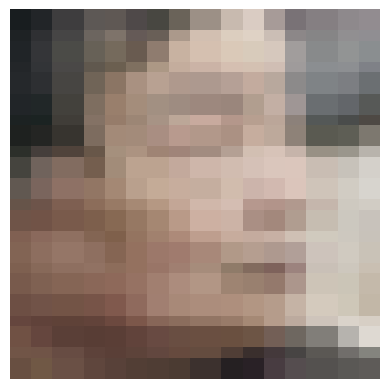

Label:  without_mask
Previsão:  without_mask
Probabilidade:  0.9549956


In [32]:
count = 0
y_pred = list()
y_true = list()
class_names = ['with_mask', 'without_mask']

# Loop do data generator de teste que contem as imagens
for batch in test_generator:

    count+=1

    # Condição de saída do loop. Só executaremos o modelo em algumas imagens
    if count == 2:
        break

    else:

        # Pegando a imagem e o label
        images = batch[0]
        labels = batch[1]

        # Previsão
        predictions = model.predict(images)

        # Visualização da imagem
        for i in range(len(images)):

            image = images[i]
            label = labels[i]
            prediction = predictions[i]

            # Converte o array de previsão para visualizar a classe e a probabilidade
            predicted_class = np.argmax(prediction)
            probability = prediction[predicted_class]
            label = class_names[int(label)]
            y_true.append(label)

            # Faz o DE-PARA da probabilidade com o tipo de classe da previsão
            class_name = 'without_mask' if prediction >= 0.5 else 'with_mask'
            y_pred.append(class_name)

            # Configura a saída das imagens que serão visualizadas
            plt.imshow(images[i])
            plt.axis('Off')
            plt.show()

            # Imprime os resultados da classificação das images
            print("Label: ", label)
            print("Previsão: ", class_name)
            print("Probabilidade: ", probability)

## 6. Avaliação do modelo de deep learning

Acurácia do modelo nos dados de teste

In [33]:
loss, accuracy = model.evaluate_generator(test_generator)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

<ipython-input-33-78954c843b8c>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy = model.evaluate_generator(test_generator)


Test: accuracy = 0.946636  ;  loss = 0.158424 


#### Visualização de métricas da avaliação do modelo

Métricas de performance do modelo no subconjunto das imagens de teste

In [34]:
accuracy = skm.accuracy_score(y_true, y_pred)
precision = skm.precision_score(y_true, y_pred, average='weighted')
recall = skm.recall_score(y_true, y_pred, average='weighted')
f1score = skm.f1_score(y_true, y_pred, average='weighted')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1score)

Accuracy:  0.96875
Precision:  0.9709821428571428
Recall:  0.96875
F1 Score:  0.9689064064064065


Matriz de confusão para identificar onde o modelo de deep learning acertou e errou na classificação do subconjunto de imagens de teste

Text(0.5, 1.0, 'Matriz de confusão')

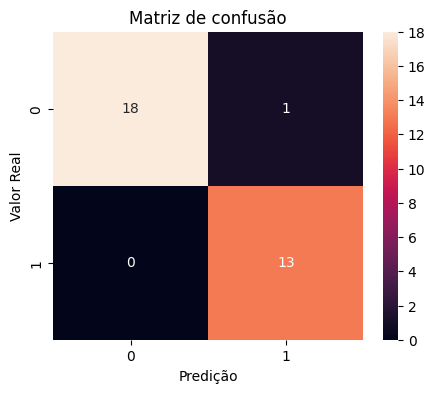

In [35]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_true,y_pred),annot=True)
plt.xlabel('Predição')
plt.ylabel('Valor Real')
plt.title('Matriz de confusão')

## 7. Exportação do modelo de deep learning para posterior uso

Salvando o modelo de deep learning que foi treinado

In [39]:
# obtendo a data e hora atual
now = datetime.now()

# Definição do formato
format = '%Y-%m-%dT%H%M'

# Converter a data e hora em uma string com o formato especificado
formatted_datetime = now.strftime(format)

path_model = 'dataset/mask/trained_models'

name_model = 'trained_model_' + formatted_datetime + '.h5'

# salvando o modelo
model.save("%s/%s" % (path_model, name_model))
print("Modelo salvo com o nome: ", name_model)

Modelo salvo com o nome:  trained_model_2023-07-19T0407.h5


## 8. Teste do modelo exportado

Carregando o modelo salvo.

Link para o modelo treinado:
https://drive.google.com/file/d/1DtVKLfzEIeMhHlYR9cVwuHiE2QcZ6mne/view?usp=sharing

In [ ]:
#Modelo treinado
#path_model = 'dataset/mask/trained_models'
#name_model = 'trained_model_20212-07-19T0407.h5'

In [42]:
file_id = "1DtVKLfzEIeMhHlYR9cVwuHiE2QcZ6mne"
url = f"https://drive.google.com/uc?id={file_id}"

folder_path = "./dataset/mask/trained_models"  # especifique a pasta onde baixara o arquivo
os.makedirs(folder_path, exist_ok=True) # cria a pasta de destino se necessário

output = path_model + "/" + name_model  # especifique o nome do arquivo e a extensão do mesmo
gdown.download(url, output)

Downloading...
From: https://drive.google.com/uc?id=1DtVKLfzEIeMhHlYR9cVwuHiE2QcZ6mne
To: /content/dataset/mask/trained_models/trained_model_2023-07-19T0407.h5
100%|██████████| 4.33M/4.33M [00:00<00:00, 215MB/s]


'dataset/mask/trained_models/trained_model_2023-07-19T0407.h5'

In [43]:
loaded_model = keras.models.load_model("%s/%s" % (path_model, name_model))
print("Modelo %s carregado com sucesso" % (name_model))

Modelo trained_model_2023-07-19T0407.h5 carregado com sucesso


Execução do modelo em um subconjunto de imagens de teste

1/1 [==============================] - 0s 178ms/step


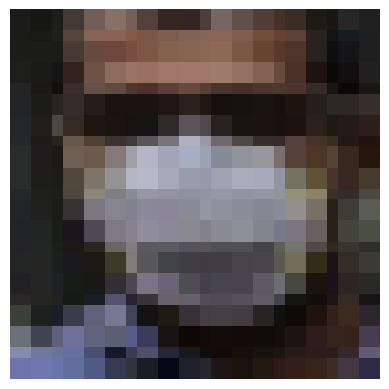

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.011064755


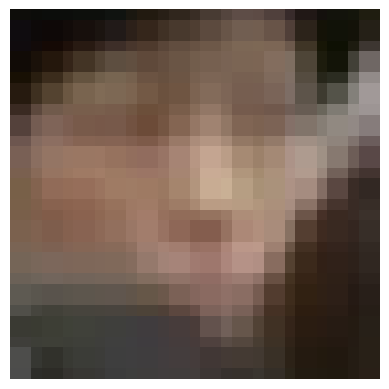

Label:  without_mask
Previsão:  without_mask
Probabilidade:  0.963546


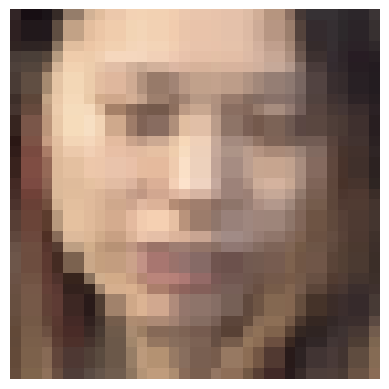

Label:  without_mask
Previsão:  without_mask
Probabilidade:  0.9775057


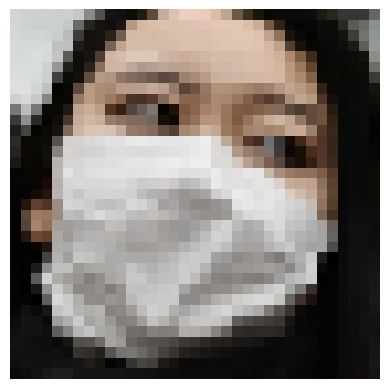

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.028934974


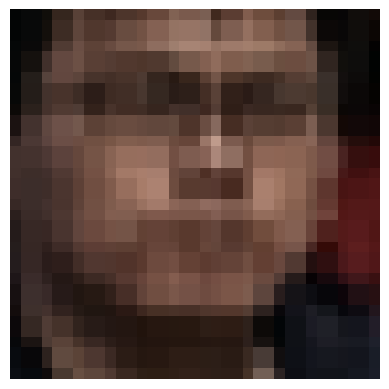

Label:  without_mask
Previsão:  without_mask
Probabilidade:  0.9559912


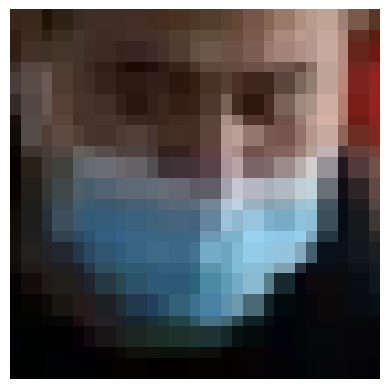

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.0007589214


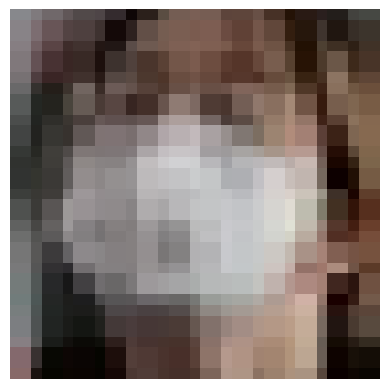

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.05340045


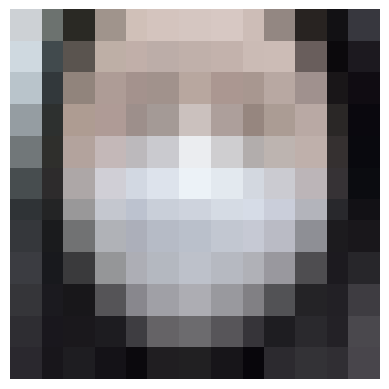

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.007120846


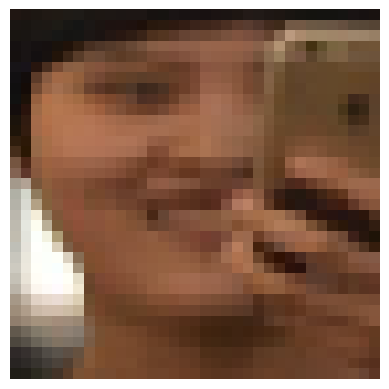

Label:  without_mask
Previsão:  without_mask
Probabilidade:  0.97417575


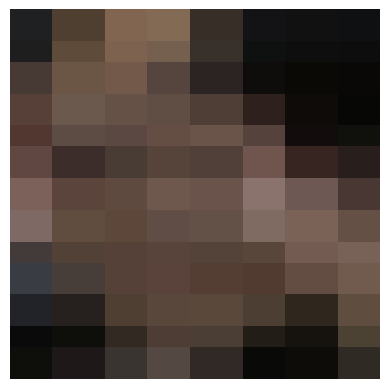

Label:  without_mask
Previsão:  without_mask
Probabilidade:  0.90629655


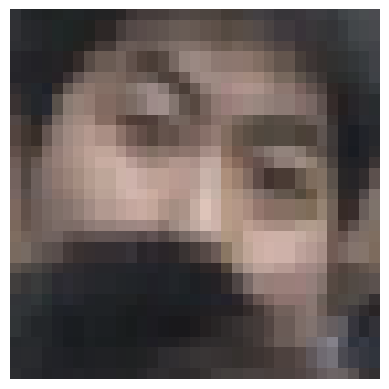

Label:  without_mask
Previsão:  without_mask
Probabilidade:  0.8786404


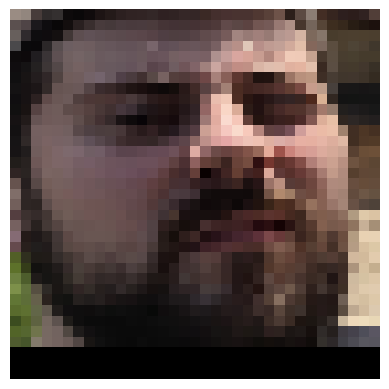

Label:  without_mask
Previsão:  without_mask
Probabilidade:  0.84900165


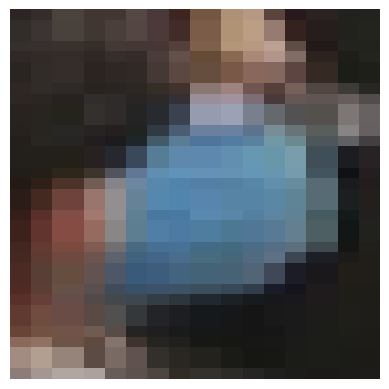

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.00030810712


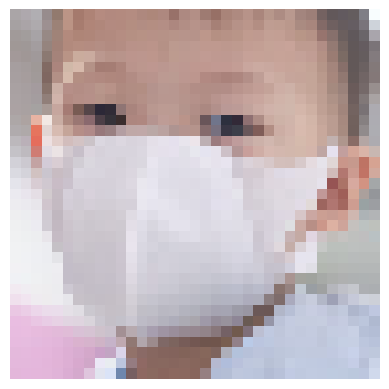

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.011826499


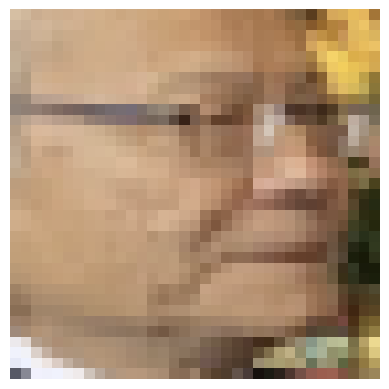

Label:  without_mask
Previsão:  without_mask
Probabilidade:  0.9833299


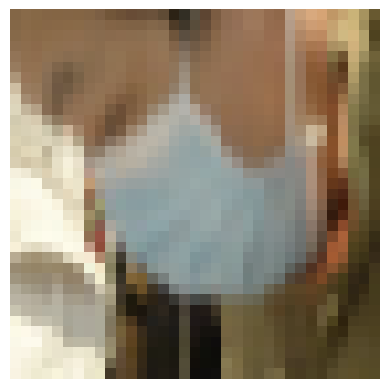

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.022923786


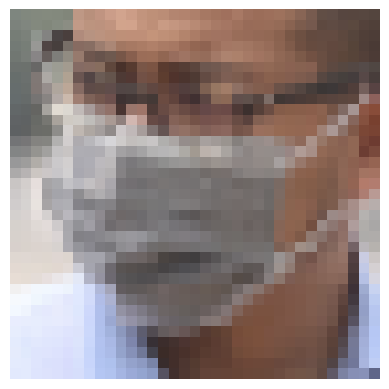

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.09405074


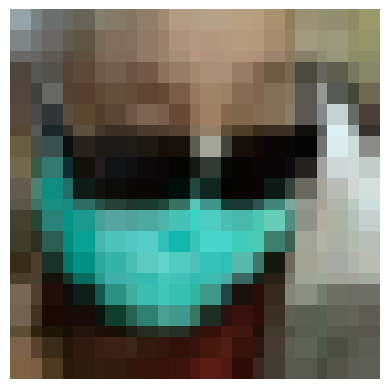

Label:  with_mask
Previsão:  with_mask
Probabilidade:  1.0333765e-05


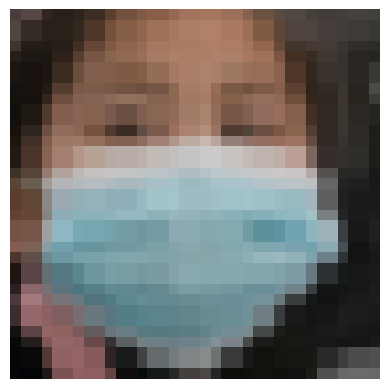

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.0011906407


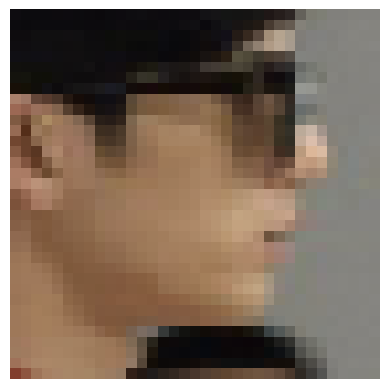

Label:  without_mask
Previsão:  without_mask
Probabilidade:  0.97602516


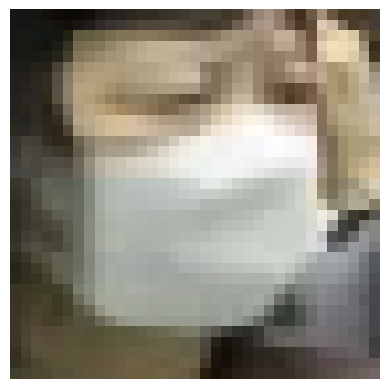

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.048504464


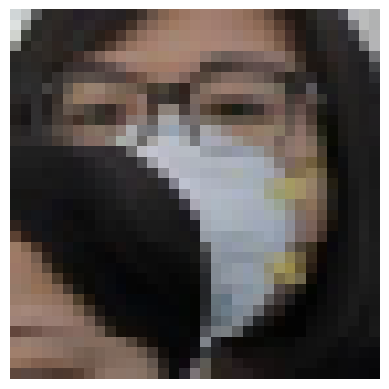

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.027975705


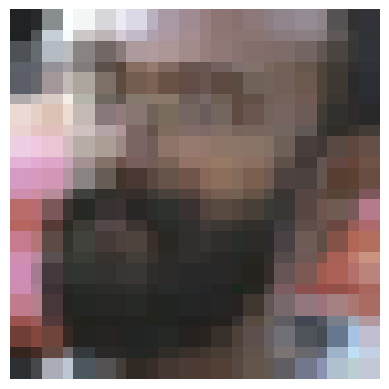

Label:  without_mask
Previsão:  without_mask
Probabilidade:  0.881972


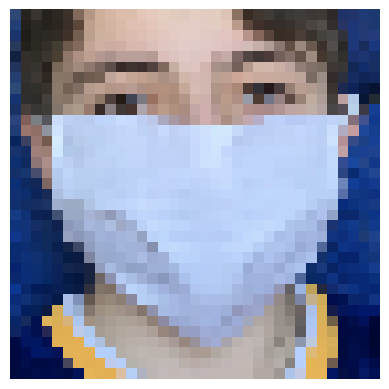

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.00011929833


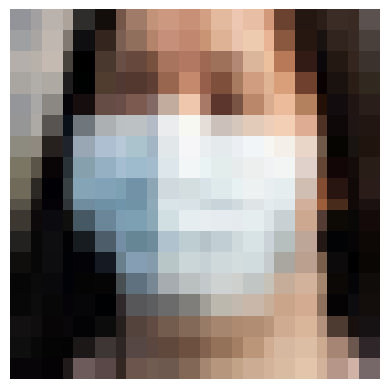

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.002460012


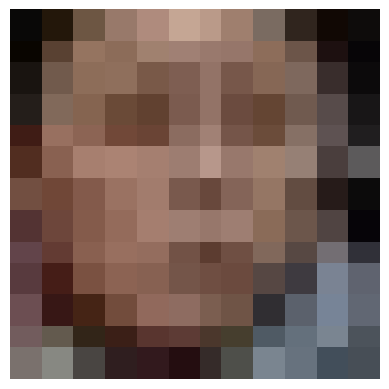

Label:  without_mask
Previsão:  without_mask
Probabilidade:  0.9614627


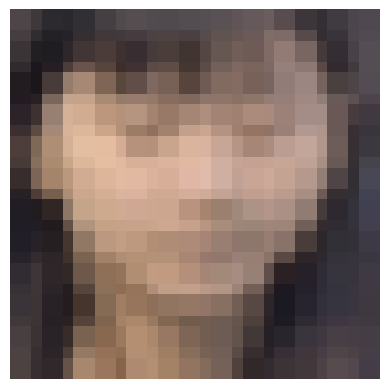

Label:  without_mask
Previsão:  without_mask
Probabilidade:  0.9751143


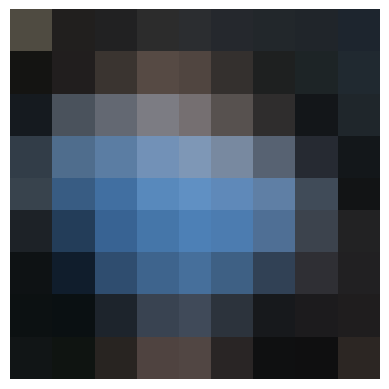

Label:  with_mask
Previsão:  with_mask
Probabilidade:  8.737918e-05


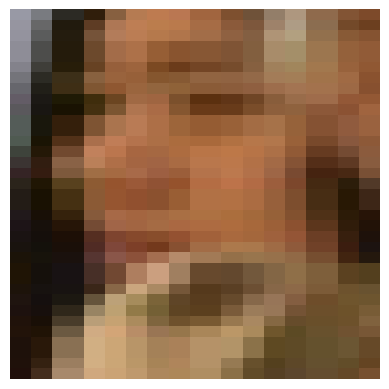

Label:  without_mask
Previsão:  without_mask
Probabilidade:  0.9828498


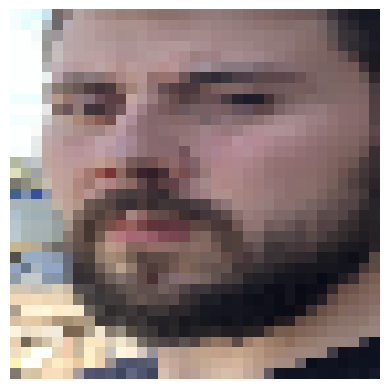

Label:  without_mask
Previsão:  without_mask
Probabilidade:  0.8859167


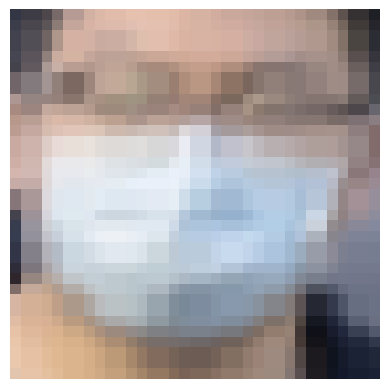

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.0009906027


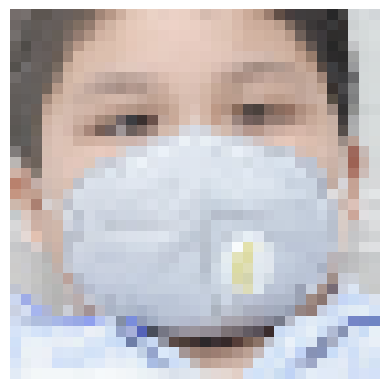

Label:  with_mask
Previsão:  with_mask
Probabilidade:  0.0033879813


In [44]:
count = 0
y_pred = list()
y_true = list()
class_names = ['with_mask', 'without_mask']

# Loop do data generator de teste que contem as imagens
for batch in test_generator:

    count+=1

    # Condição de saída do loop, caso seja necessário executar o modelo em apenas algumas imagens
    if count == 2:
        break

    else:

        # Pegando a imagem e o label
        images = batch[0]
        labels = batch[1]

        # Previsão
        predictions = loaded_model.predict(images)

        # Visualização da imagem
        for i in range(len(images)):

            image = images[i]
            label = labels[i]
            prediction = predictions[i]

            # Converte o array de previsão para visualizar a classe e a probabilidade
            predicted_class = np.argmax(prediction)
            probability = prediction[predicted_class]
            label = class_names[int(label)]
            y_true.append(label)

            # Faz o DE-PARA da probabilidade com o tipo de classe da previsão
            class_name = 'without_mask' if prediction >= 0.5 else 'with_mask'
            y_pred.append(class_name)

            # Configura a saída das imagens que serão visualizadas
            plt.imshow(images[i])
            plt.axis('Off')
            plt.show()

            # Imprime os resultados da classificação das images
            print("Label: ", label)
            print("Previsão: ", class_name)
            print("Probabilidade: ", probability)

# Conclusão

Os desafios para classificação de usuários com máscara e sem máscara envolvem tanto o posicionamento, cor da máscara, tipo de máscara, pessoas com e sem barba, dentre outros.

Além disso, eram tamanhos de imagens bastante distintas e resoluções diferentes, causados pelas diferentes "bounding box" registradas nas imagens originais.

Mesmo assim, o modelo obtido gerou resultados satisfatórios para a classificação de usuários com máscara e sem máscara, com acurácia acima de 90%.